In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
url='https://drive.google.com/file/d/0BwT5wj_P7BKXUl9tOUJWYzVvUjA/view?resourcekey=0-uFrn8bQkUfSCvJlmtKGCdQ'
url_='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url_)

In [3]:
special_category = df[(df[' Category'] == 'BEFORE & AFTER') | (df[' Category'] == 'SCIENCE') | (df[' Category'] == 'LITERATURE')]
special_category = special_category[ [' Category', ' Question']]
special_category.dropna()
special_category.reset_index(inplace=True)

In [7]:
import re
import string
from nltk.corpus import stopwords
def clean_text(text):
    stop_words = stopwords.words("english")
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"href*\S+", " ", text)
    text = re.sub(r"target*\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

for index in range(len(special_category)):
    special_category.loc[index, ' Question'] = clean_text(special_category[' Question'].values[index])

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [12]:
X_train, X_test, y_train, y_test = train_test_split(special_category[' Question'], special_category[' Category'], test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(936,) (936,)
(313,) (313,)


In [47]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

vectorize_layer = keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=MAX_NB_WORDS,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

vectorize_layer.adapt(special_category[' Question'].values)
X = vectorize_layer(special_category[' Question'].values).numpy()
print('Shape of label tensor:', X.shape)

Shape of label tensor: (1562, 100)


In [48]:
Y = pd.get_dummies(special_category[' Category'].values, dtype=float)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1562, 3)


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1405, 100) (1405, 3)
(157, 100) (157, 3)


In [53]:
model = Sequential([
    tf.keras.layers.Input(shape=(None,), dtype="int64"),
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 100)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080,703 (7.94 MB)

 Trainable params: 2,080,703 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.3291 - loss: 1.0999 - val_accuracy: 0.3688 - val_loss: 1.0992
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.3376 - loss: 1.0986 - val_accuracy: 0.3688 - val_loss: 1.0920
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3343 - loss: 1.1001 - val_accuracy: 0.3688 - val_loss: 1.0953
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3550 - loss: 1.0979 - val_accuracy: 0.3688 - val_loss: 1.1004
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.3146 - loss: 1.1017 - val_accuracy: 0.3688 - val_loss: 1.0973


In [67]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4176 - loss: 1.0979
Test set
  Loss: 1.098
  Accuracy: 0.401


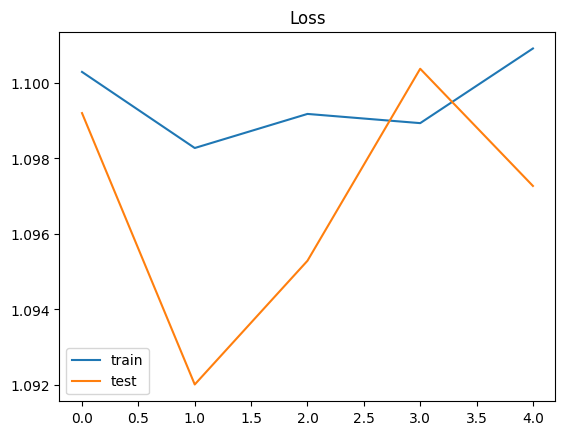

In [68]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [77]:
X = vectorize_layer(special_category[' Question'].values)
vocab = vectorize_layer.get_vocabulary()
vocabulary_size = len(vocab)
print(vocabulary_size)

5774


In [78]:
embedding_dim = 100

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for idx, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

In [79]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocabulary_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False  # Freeze the embeddings during training
)

In [80]:
model = Sequential([
    tf.keras.layers.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 100)      │       577,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,103 (2.51 MB)

 Trainable params: 80,703 (315.25 KB)

 Non-trainable params: 577,400 (2.20 MB)

None


In [82]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.3348 - loss: 1.0991 - val_accuracy: 0.3688 - val_loss: 1.0990
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3228 - loss: 1.0989 - val_accuracy: 0.3688 - val_loss: 1.0960
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.3526 - loss: 1.0983 - val_accuracy: 0.3688 - val_loss: 1.0972
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.3494 - loss: 1.0983 - val_accuracy: 0.3688 - val_loss: 1.0953
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3273 - loss: 1.0994 - val_accuracy: 0.3688 - val_loss: 1.0977


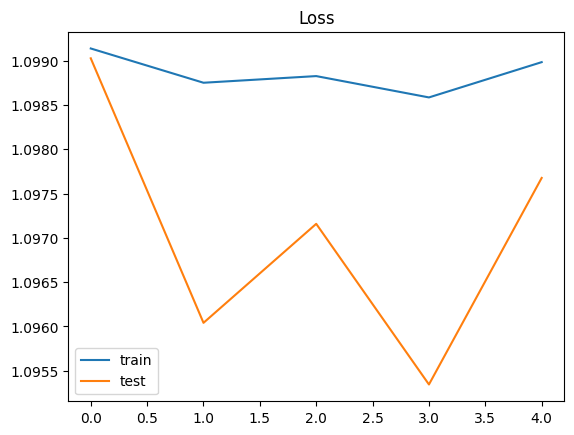

In [83]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()